In [2]:
#import libraies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import log_loss
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir='data'

In [5]:
#import train and test_data
train_0=pd.read_csv(data_dir + "/train_0.csv")
# train_1 = pd.read_csv(data_dir + "/train_1.csv")
# train_2 = pd.read_csv(data_dir + "/train_2.csv")
# train_3 = pd.read_csv(data_dir + "/train_3.csv")
test = pd.read_csv(data_dir + "/test.csv")
train_0.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.8048,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.2616,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.2270,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993190,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.8984,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.9606,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


In [6]:
test.head()

,id,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,...,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer
0,0,-56.270800,29.510000,17.348600,24.4994,-1.3114,11.006801,-35.776200,73.136800,1.2480,...,3.9484,-16.710800,0.0074,71.00,0.0000,-3.264,-6.1330,-6.8750,-7.016,-3.230
1,1,2.852800,70.196000,8.949000,-8.1522,-65.5772,18.536400,22.926000,87.543800,0.3396,...,-15.4968,-14.876600,0.0050,66.70,0.0000,-1.615,-5.9700,-5.5040,0.000,-6.510
2,2,52.366400,-98.036800,14.249001,-2.0000,-45.2914,-15.423400,51.288998,-102.055595,6.3570,...,0.9058,-27.413600,0.0042,80.40,-0.0316,0.000,0.0000,-3.1290,0.000,-3.678
3,3,36.365402,53.961403,23.161798,24.8294,-10.3286,-0.918000,16.424799,0.932800,0.3402,...,-5.0532,-15.106999,0.0052,96.06,-6.4300,-4.090,-7.8320,-5.7600,0.000,-3.924
4,4,-23.262400,-53.391003,21.209600,-1.6676,-24.7788,3.481200,-19.681800,-93.913605,4.7832,...,22.2000,24.928001,0.0042,0.00,-9.8800,0.000,-0.4456,-0.4915,-7.830,0.000


In [7]:
train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149381 entries, 0 to 2149380
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   game_num                     int64  
 1   event_id                     int64  
 2   event_time                   float64
 3   ball_pos_x                   float64
 4   ball_pos_y                   float64
 5   ball_pos_z                   float64
 6   ball_vel_x                   float64
 7   ball_vel_y                   float64
 8   ball_vel_z                   float64
 9   p0_pos_x                     float64
 10  p0_pos_y                     float64
 11  p0_pos_z                     float64
 12  p0_vel_x                     float64
 13  p0_vel_y                     float64
 14  p0_vel_z                     float64
 15  p0_boost                     float64
 16  p1_pos_x                     float64
 17  p1_pos_y                     float64
 18  p1_pos_z                     float64
 19  

*Those data are float64  and we can save memory to converting this into float32 without losing any information*

In [8]:
train_0['p1_pos_y']=train_0['p1_pos_y'].astype('float32')
train_0['p1_pos_y'].dtypes

dtype('float32')

In [9]:
#Number of Coulumns in dataset
train_0.columns

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

Lets, Understand the data First,
- In data section, `game_num` defines the event and `event_id` shows you the consucutive frame means which event happend after current event.
- `event_time` work on 10 second gap which identified goal happen in that time or not.
- `ball_pos_[xyz]` Ball position identifier in 3d vector ball could be x,y and z positions.
- `ball_vel_[xyz]` Same as ball position, here tell about the speed of ball.
- `p{i}_pos_[xyz]` Player position in 3d vector, we know there have six player so position could be six types.
- `p{i}_vel_[xyz]` What is the speed of each player .
- `p{i}_boost` Boost could be 100 and that is the hight limit.
- `boost{i}_timer` Timer to go boost from which time to and slow speed time.
- `player_scoring_next` which player score a goal among six if no goal happen in current event then -1
- `team_scoring_next` Which team scor next A or B.
- `team_[A|B]_scoring_within_10sec` Goal happen then 1 otherwise 0 in 1- sec.

*Now Check the Target Column*

Text(0.5, 1.0, 'Which team scroing Next ')

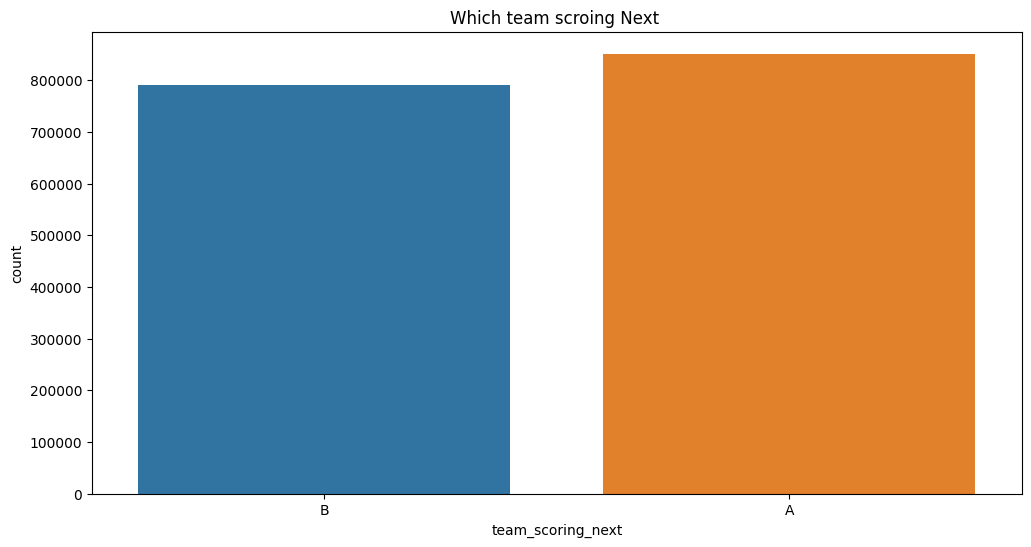

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(x='team_scoring_next', data=train_0)
plt.title("Which team scroing Next ")

Text(0.5, 1.0, 'which player score next')

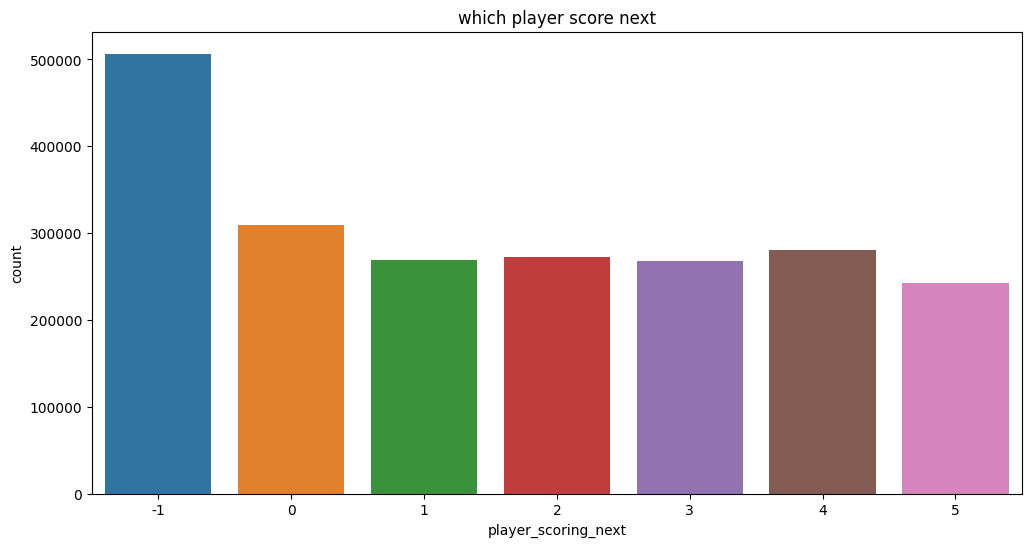

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='player_scoring_next', data=train_0)
plt.title('which player score next')

Insight:
- Class imbalance dataset
- Which team score next in B but at the goal with 10 second in B is 0.
- Player scoring next is -1 because No goal happen in maximum 10 seconds event.
- From A team 0 number Player Score highest GOAL
- From B team 4 Number player score Most GOAL

We can see the co-relation map to identified which features are related to the target variable and we should drop which one.

<AxesSubplot: >

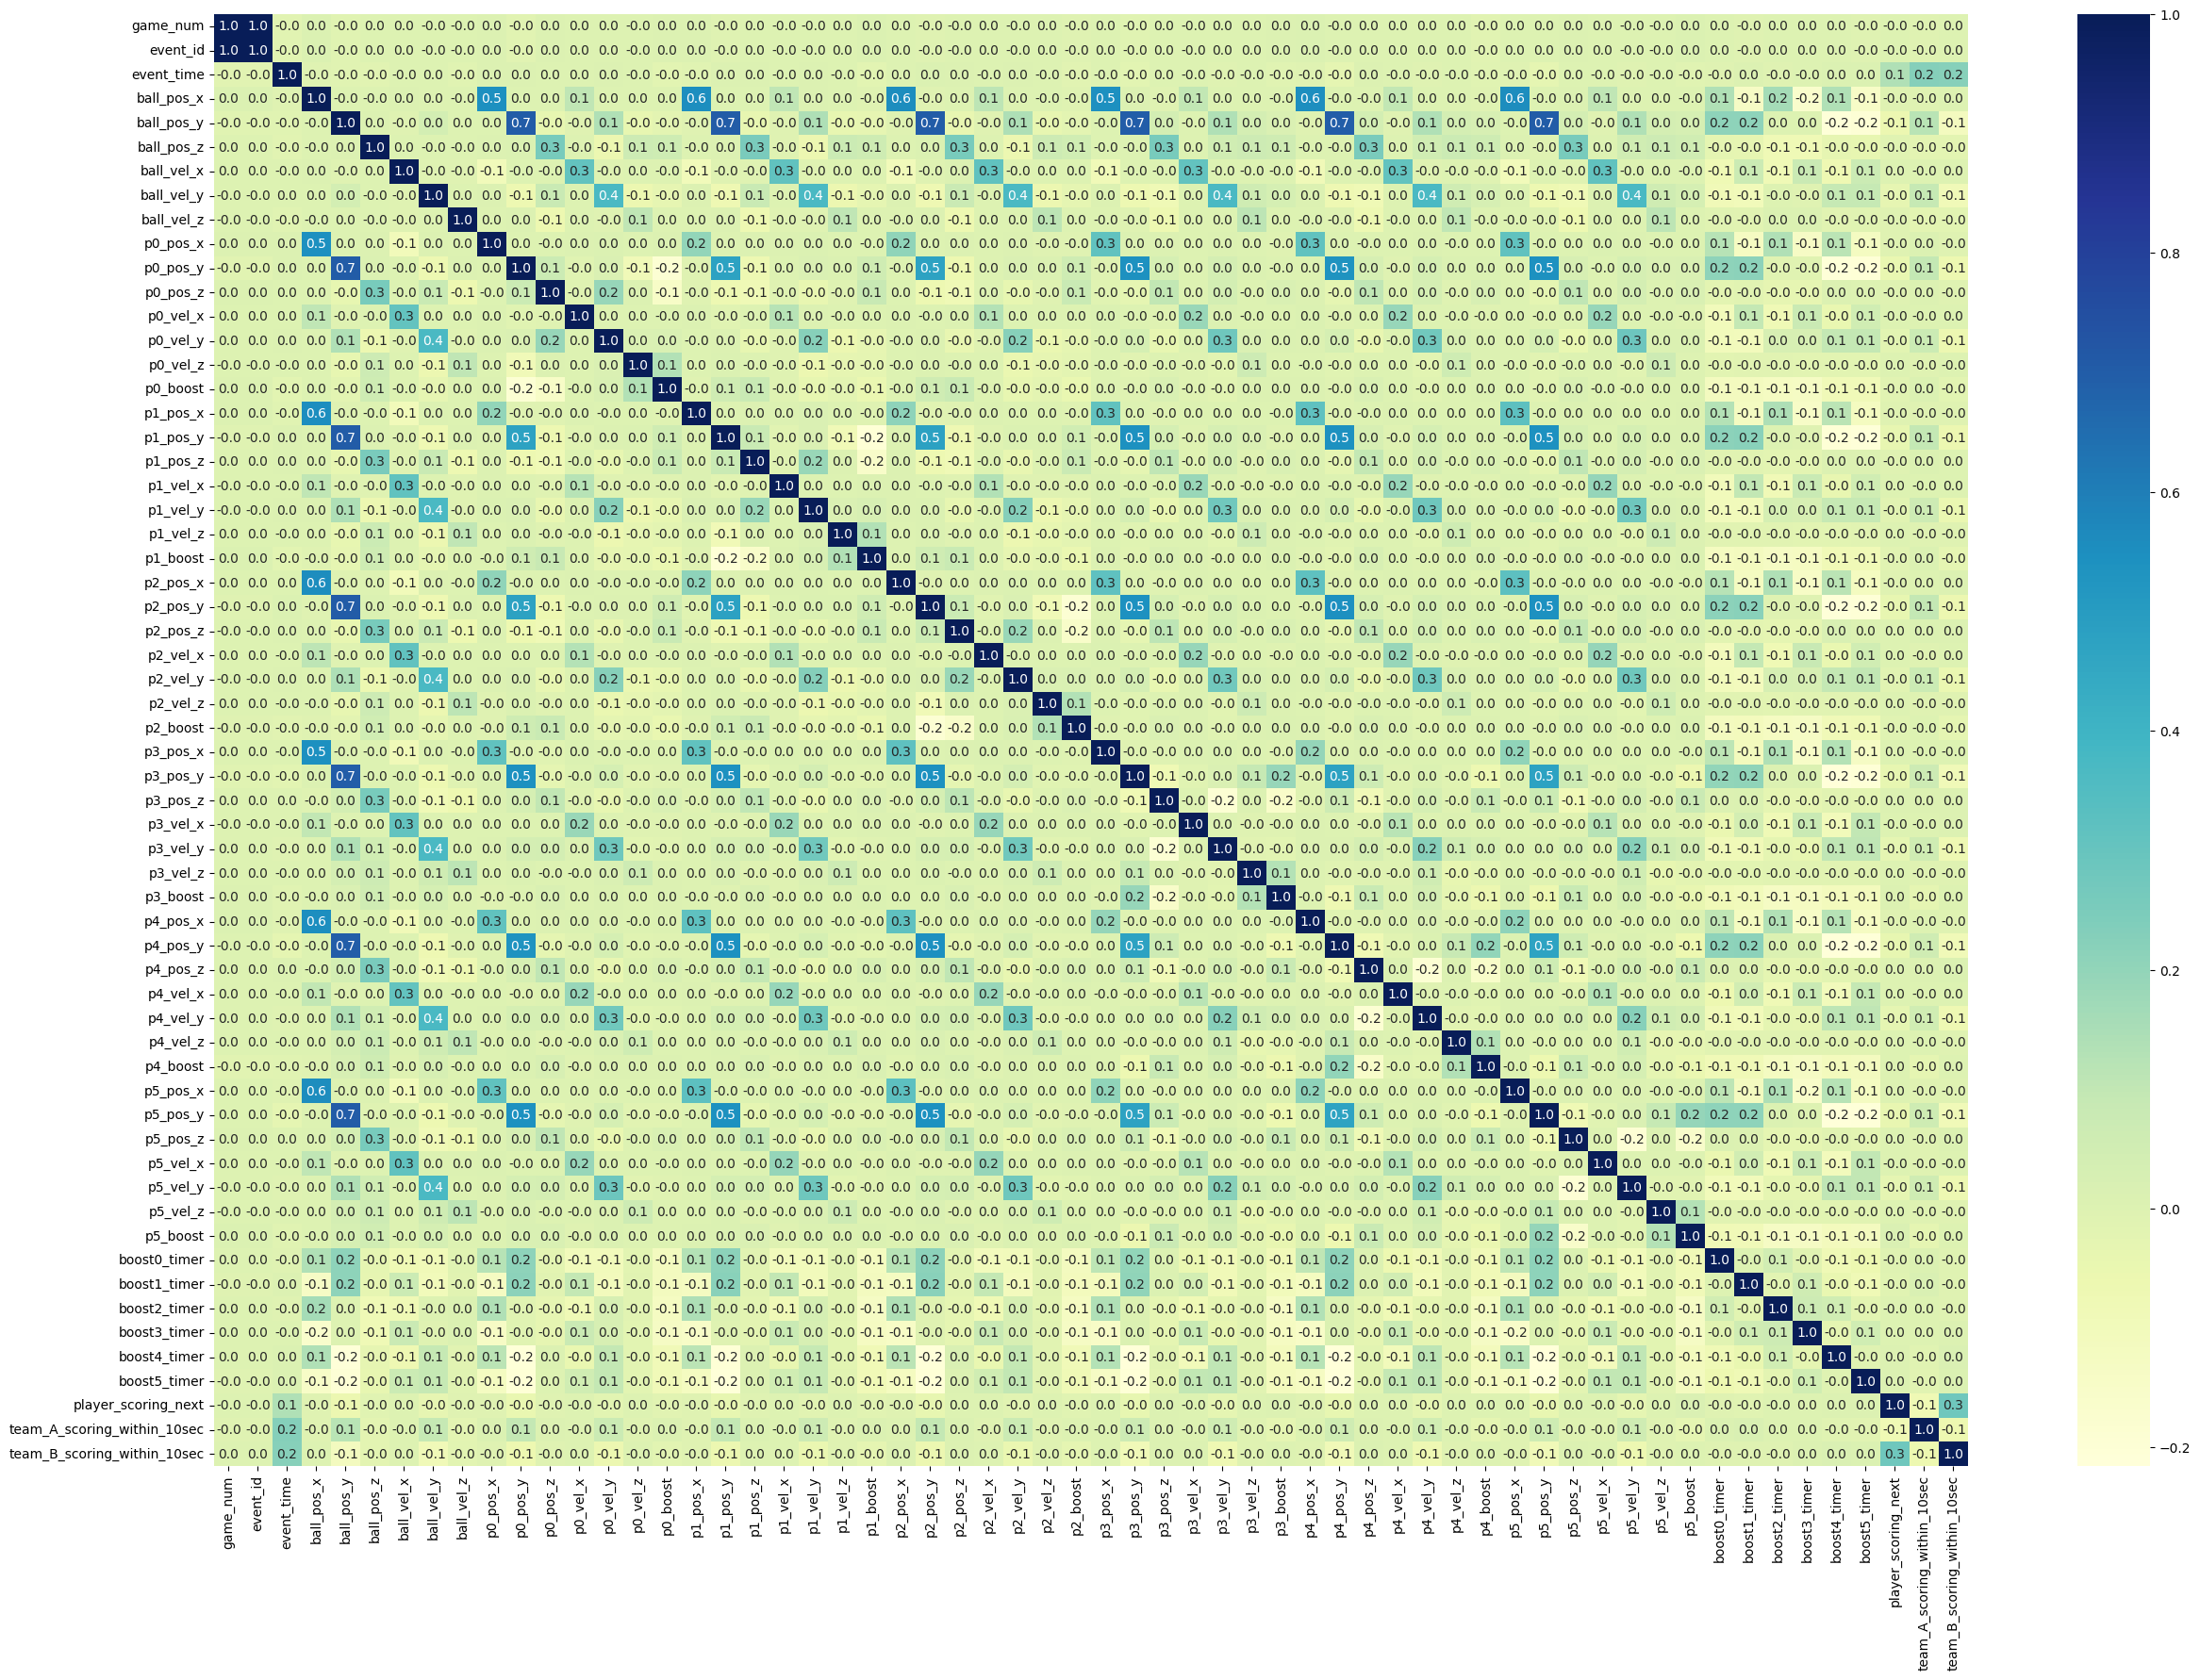

In [12]:
matrix_correlations=train_0.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(matrix_correlations, cmap="YlGnBu", annot=True, fmt=".1f")

Lets combine several columns and then check what Next

In [11]:
train_0['bal_position']= train_0['ball_pos_x']+train_0['ball_pos_y']+train_0['ball_pos_z']
train_0['bal_velocity'] =train_0['ball_vel_x']+train_0['ball_vel_y']+train_0['ball_vel_z']
train_0['target']=train_0['team_A_scoring_within_10sec'] + train_0['team_B_scoring_within_10sec']

> **Ball Position can help or Not**

In [12]:
Score_A=len(train_0[(train_0['bal_position'] > 90 ) & (train_0['team_A_scoring_within_10sec']==1)])
Score_B = len(train_0[(train_0['bal_position']>90)& (train_0['team_B_scoring_within_10sec']==1)])
display(Score_A)
display(Score_B)

39343

12333

Insights: 
- Ball position affect the score.
- Ball position affect the score of A team more than B team
- Ball Position values decrease the score of B.


> **Ball_velocity Can help or not**

In [13]:
train_0['bal_velocity'].min()

-146.22199999999998

In [14]:
core_A=len(train_0[(train_0['bal_velocity'] < 90 ) & (train_0['team_A_scoring_within_10sec']==1)])
Score_B = len(train_0[(train_0['bal_velocity']<90)& (train_0['team_B_scoring_within_10sec']==1)])
display(Score_A)
display(Score_B)

39343

119528

In [15]:
del core_A, Score_B

Insight: 
- What happen if we take the less  ball velosity to calculate B
- & hight velosity margin for Calculate A

In [16]:
#check out the null_values
train_0.isnull().sum().sort_values(ascending=False).head(10)

team_scoring_next    506604
p3_pos_z              19830
p3_boost              19830
p3_vel_z              19830
p3_vel_y              19830
p3_vel_x              19830
p3_pos_y              19830
p3_pos_x              19830
p2_pos_x              19517
p2_boost              19517
dtype: int64

##### Check the team performance and Datashape

Text(0.5, 1.0, 'Team A Score within 10 Second')

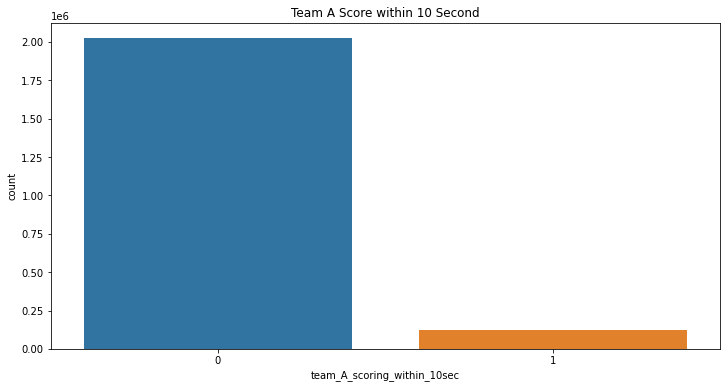

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(x='team_A_scoring_within_10sec', data=train_0)
plt.title("Team A Score within 10 Second")

Insight:
- In classification section 0 is more than 1.
- With hugely Imbalance dataset

# Class Imbalance

For class Imbalance we can create duplicate one or Used <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html">StratifiedKFold</a> cross validation. More information about class Imbalance <a href="https://machinelearningmastery.com/what-is-imbalanced-classification/"> visit that.</a>

There are several technique to deal with Class imbalance:
1. **Random Under-Sampling:** Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.
2. **Random Over-Sampling:** Oversampling can be defined as adding more copies to the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
3. **Under-sampling: Tomek links:** Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.
4. **Synthetic Minority Oversampling Technique (SMOTE):** SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
5. **Change the performance metric:** Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.

More about class Imbalance Visit: <a href="https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/">See this turorial</a>

##  Modeling 

* Lets concat those data for training, In thia section we only used half 4 subset of full dataset

In [19]:
# try to uf you have enough memory
# train_df = pd.concat([train_0, train_3]) #memory capacity we take three of them
# train_df.head()

In [20]:
y_A =train_0['team_A_scoring_within_10sec']
y_B=train_0['team_B_scoring_within_10sec']

In [21]:
featurs = train_0.columns[3:-18] 
df_train=train_0[featurs].copy()
df_test=test[featurs].copy()
featurs

Index(['ball_pos_x', 'ball_pos_y', 'ball_pos_z', 'ball_vel_x', 'ball_vel_y',
       'ball_vel_z', 'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x',
       'p0_vel_y', 'p0_vel_z', 'p0_boost', 'p1_pos_x', 'p1_pos_y', 'p1_pos_z',
       'p1_vel_x', 'p1_vel_y', 'p1_vel_z', 'p1_boost', 'p2_pos_x', 'p2_pos_y',
       'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 'p2_boost', 'p3_pos_x',
       'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z', 'p3_boost',
       'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y', 'p4_vel_z',
       'p4_boost', 'p5_pos_x', 'p5_pos_y'],
      dtype='object')

In [22]:
del train_0

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train))
df_test = pd.DataFrame(scaler.transform(df_test))

## Training with StratifiedKFold for Secor_A and Score_B

In [26]:
params = {
            'objective':'binary:logistic',
            'tree_method': 'gpu_hist',
            'booster' : 'gbtree',
            'subsample' : 0.8326,
            'gamma' : 0.48,
            'max_depth': 12,
            'alpha': 10,
            'learning_rate': .017,
            'n_estimators':1000, 
            'predictor': 'gpu_predictor'
        }       
           

In [27]:
df_train.shape

(2149381, 43)

In [28]:
FOLDS = 5
seed=42
predA,y_pred,xgb_val,scores=[],[],[],[]
def model_fit(df_train, y_A, X_test):
#     predA,y_pred,xgb_val,scores=[],[],[],[]
    k_fold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(df_train, y_A)):
        X_fold_train, Y_fold_train = df_train.iloc[train_idx,:], y_A[train_idx]
        X_fold_val, Y_fold_val = df_train.iloc[val_idx,:], y_A[val_idx]
        print(f"--------FOLD-{fold+1}--------")
    
        #start model
        xgb = XGBClassifier(**params)
        eval_set = [(X_fold_train, Y_fold_train), (X_fold_val, Y_fold_val)]
        xgb.fit(X_fold_train, Y_fold_train,
              early_stopping_rounds=150,
        #           eval_set=[(test_X,y_test)],
            eval_set=eval_set,
             eval_metric=["error", "logloss"],
              verbose=500)
        #check score
        eval_set = xgb.predict_proba(X_fold_val)[:,1]
        y_pred.append(Y_fold_val)
        xgb_val.append(eval_set)
        predA = xgb.predict_proba(X_test)[:,1]
        score=log_loss(Y_fold_val, eval_set)
        print(f"Validation Logloss  = {score:.4f}")
        scores.append(score)
        del X_fold_train, Y_fold_train, X_fold_val, Y_fold_val
    return predA

In [29]:
#model fit for A
model_fit(df_train, y_A, df_test)

--------FOLD-1--------
[0]	validation_0-error:0.05610	validation_0-logloss:0.67974	validation_1-error:0.05642	validation_1-logloss:0.67976
[500]	validation_0-error:0.04059	validation_0-logloss:0.09615	validation_1-error:0.04836	validation_1-logloss:0.11572
[999]	validation_0-error:0.01868	validation_0-logloss:0.06111	validation_1-error:0.03571	validation_1-logloss:0.08278
Validation Logloss  = 0.0828
--------FOLD-2--------
[0]	validation_0-error:0.05599	validation_0-logloss:0.67974	validation_1-error:0.05632	validation_1-logloss:0.67975
[500]	validation_0-error:0.04048	validation_0-logloss:0.09597	validation_1-error:0.04847	validation_1-logloss:0.11504
[999]	validation_0-error:0.01870	validation_0-logloss:0.06103	validation_1-error:0.03554	validation_1-logloss:0.08226
Validation Logloss  = 0.0823
--------FOLD-3--------
[0]	validation_0-error:0.05589	validation_0-logloss:0.67974	validation_1-error:0.05648	validation_1-logloss:0.67976
[500]	validation_0-error:0.04098	validation_0-logloss

array([0.01395857, 0.00847488, 0.00786526, ..., 0.07795541, 0.02220259,
       0.00959365], dtype=float32)

In [30]:
print(f'score:{np.mean(scores):0.4f}')
scores

score:0.0825


[0.08278242207375375,
 0.08225978870084692,
 0.08250564894207954,
 0.08227625037117253,
 0.0827548852797341]

In [31]:
#model fit for B
model_fit(df_train, y_B, df_test)

--------FOLD-1--------
[0]	validation_0-error:0.05328	validation_0-logloss:0.67960	validation_1-error:0.05375	validation_1-logloss:0.67962
[500]	validation_0-error:0.04029	validation_0-logloss:0.09550	validation_1-error:0.04712	validation_1-logloss:0.11392
[999]	validation_0-error:0.01821	validation_0-logloss:0.05927	validation_1-error:0.03437	validation_1-logloss:0.07999
Validation Logloss  = 0.0800
--------FOLD-2--------
[0]	validation_0-error:0.05357	validation_0-logloss:0.67960	validation_1-error:0.05399	validation_1-logloss:0.67962
[500]	validation_0-error:0.04027	validation_0-logloss:0.09552	validation_1-error:0.04730	validation_1-logloss:0.11413
[999]	validation_0-error:0.01808	validation_0-logloss:0.05889	validation_1-error:0.03448	validation_1-logloss:0.07957
Validation Logloss  = 0.0796
--------FOLD-3--------
[0]	validation_0-error:0.05354	validation_0-logloss:0.67960	validation_1-error:0.05391	validation_1-logloss:0.67961
[500]	validation_0-error:0.04015	validation_0-logloss

array([0.00926045, 0.0345656 , 0.08187833, ..., 0.01433377, 0.24188122,
       0.01776142], dtype=float32)

In [32]:
print(f'score:{np.mean(scores):0.4f}')
scores

score:0.0808


[0.08278242207375375,
 0.08225978870084692,
 0.08250564894207954,
 0.08227625037117253,
 0.0827548852797341,
 0.0799912416387505,
 0.07957440707247744,
 0.07899971301375401,
 0.07888504337595224,
 0.07838677221964174]

# Now lets go to submission

 Again set the parameter based on the ovefiting knowledge from StratifiedKFold training, Look after which  `n_estimators` training goes into overfit.

In [33]:
params = {
            'objective':'binary:logistic',
            'tree_method': 'gpu_hist',
            'booster' : 'gbtree',
            'subsample' : 0.8326,
            'gamma' : 0.48,
            'max_depth': 12,
            'alpha': 10,
            'learning_rate': .017,
            'n_estimators':700,
            'predictor': 'gpu_predictor'
        }       
           

In [34]:
#predict for score A
xgb = XGBClassifier(**params)
eval_set = [(df_train, y_A)]
xgb.fit(df_train, y_A,
          early_stopping_rounds=150,
#           eval_set=[(test_X,y_test)],
        eval_set=eval_set,
         eval_metric=["error", "logloss"],
          verbose=True)

[0]	validation_0-error:0.05560	validation_0-logloss:0.67972
[1]	validation_0-error:0.05571	validation_0-logloss:0.66674
[2]	validation_0-error:0.05565	validation_0-logloss:0.65419
[3]	validation_0-error:0.05577	validation_0-logloss:0.64205
[4]	validation_0-error:0.05579	validation_0-logloss:0.63030
[5]	validation_0-error:0.05575	validation_0-logloss:0.61891
[6]	validation_0-error:0.05577	validation_0-logloss:0.60787
[7]	validation_0-error:0.05572	validation_0-logloss:0.59718
[8]	validation_0-error:0.05575	validation_0-logloss:0.58681
[9]	validation_0-error:0.05577	validation_0-logloss:0.57677
[10]	validation_0-error:0.05580	validation_0-logloss:0.56701
[11]	validation_0-error:0.05578	validation_0-logloss:0.55753
[12]	validation_0-error:0.05579	validation_0-logloss:0.54833
[13]	validation_0-error:0.05580	validation_0-logloss:0.53940
[14]	validation_0-error:0.05582	validation_0-logloss:0.53072
[15]	validation_0-error:0.05584	validation_0-logloss:0.52229
[16]	validation_0-error:0.05582	va

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.48, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.017, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
              random_state=0, reg_alpha=10, ...)

In [35]:
predA = xgb.predict_proba(df_test)[:,1]

In [36]:
predA

array([0.02658997, 0.0113346 , 0.00905861, ..., 0.05638446, 0.0106044 ,
       0.01079042], dtype=float32)

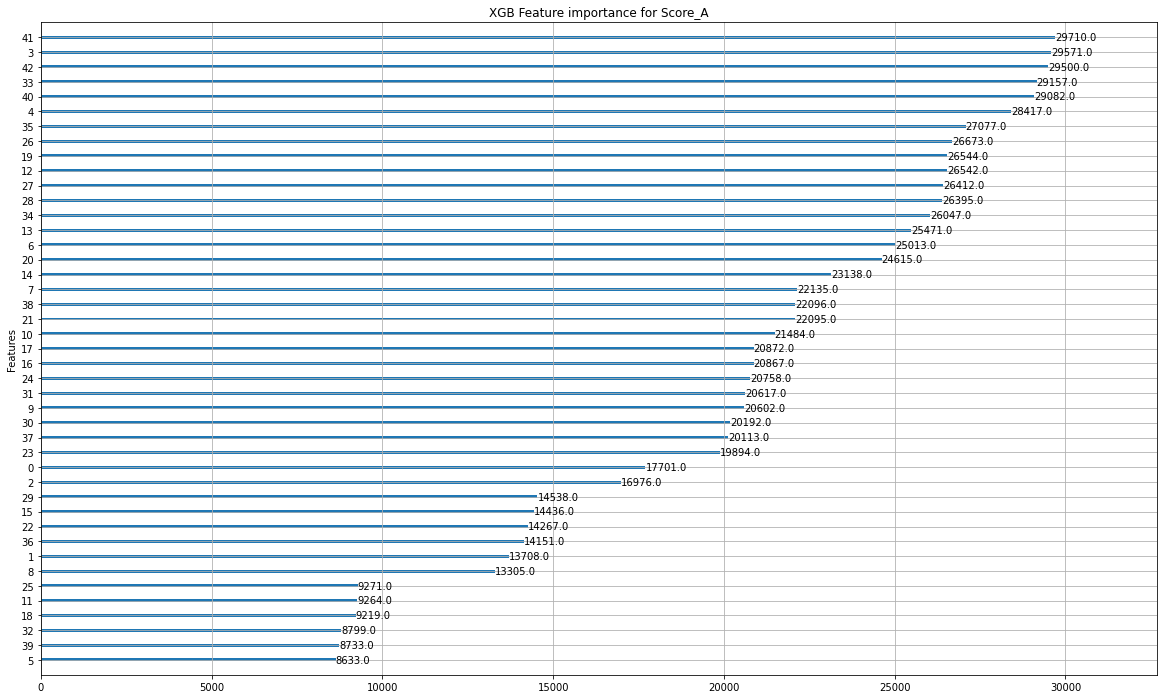

In [37]:
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(xgb,ax=ax, xlabel=None)
plt.title('XGB Feature importance for Score_A')
plt.show()

### Now for Score_B for Predicion

In [38]:
xgb = XGBClassifier(**params)
eval_set = [(df_train, y_B)]
xgb.fit(df_train, y_B,
          early_stopping_rounds=150,
#           eval_set=[(test_X,y_test)],
        eval_set=eval_set,
         eval_metric=["error", "logloss"],
          verbose=True)

[0]	validation_0-error:0.05332	validation_0-logloss:0.67959
[1]	validation_0-error:0.05333	validation_0-logloss:0.66648
[2]	validation_0-error:0.05347	validation_0-logloss:0.65381
[3]	validation_0-error:0.05345	validation_0-logloss:0.64154
[4]	validation_0-error:0.05352	validation_0-logloss:0.62967
[5]	validation_0-error:0.05359	validation_0-logloss:0.61817
[6]	validation_0-error:0.05356	validation_0-logloss:0.60702
[7]	validation_0-error:0.05357	validation_0-logloss:0.59621
[8]	validation_0-error:0.05356	validation_0-logloss:0.58574
[9]	validation_0-error:0.05360	validation_0-logloss:0.57559
[10]	validation_0-error:0.05360	validation_0-logloss:0.56573
[11]	validation_0-error:0.05358	validation_0-logloss:0.55617
[12]	validation_0-error:0.05360	validation_0-logloss:0.54689
[13]	validation_0-error:0.05362	validation_0-logloss:0.53789
[14]	validation_0-error:0.05359	validation_0-logloss:0.52914
[15]	validation_0-error:0.05358	validation_0-logloss:0.52063
[16]	validation_0-error:0.05358	va

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.48, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.017, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
              random_state=0, reg_alpha=10, ...)

In [39]:
predB = xgb.predict_proba(df_test)[:,1]

In [40]:
predB 

array([0.00911038, 0.05991426, 0.0758336 , ..., 0.01947546, 0.26319754,
       0.02237692], dtype=float32)

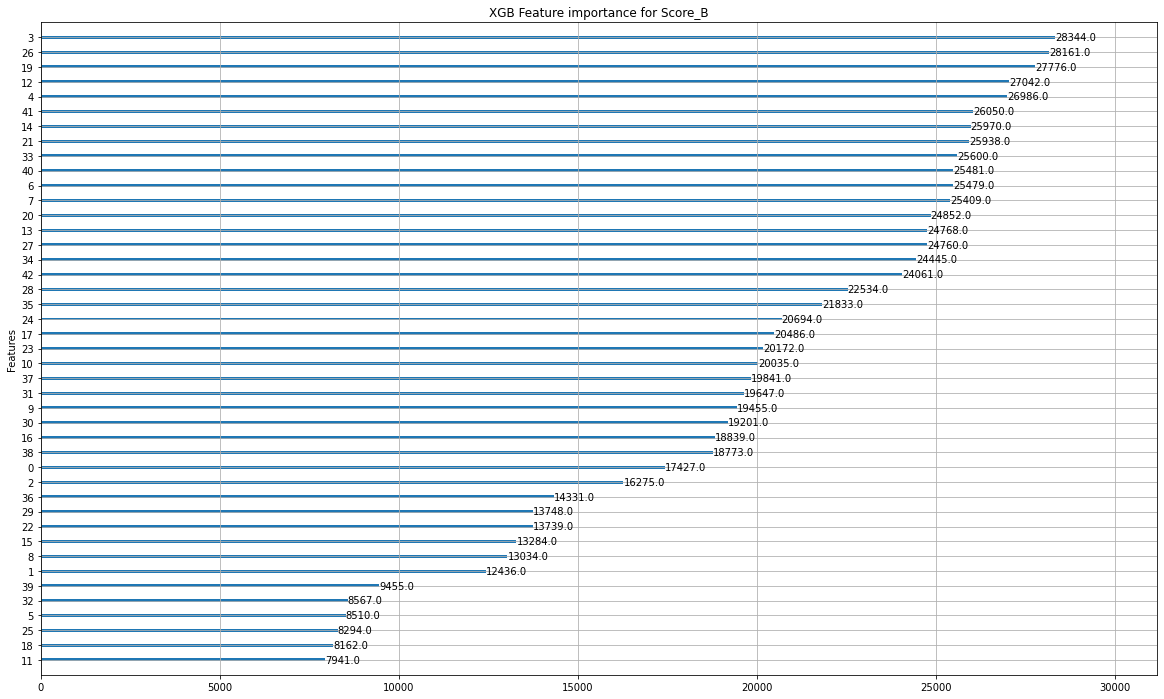

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(xgb,ax=ax, xlabel=None)
plt.title('XGB Feature importance for Score_B')
plt.show()

### Merge Score_A and Score_B for Submission

In [42]:
sub = pd.read_csv("../input/tabular-playground-series-oct-2022/sample_submission.csv")

sub["team_A_scoring_within_10sec"] = predA
sub["team_B_scoring_within_10sec"] = predB

sub.to_csv("submission.csv",index=False)

In [43]:
sub.head(5)

,id,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,0,0.026590,0.009110
1,1,0.011335,0.059914
2,2,0.009059,0.075834
3,3,0.053739,0.015912
4,4,0.009393,0.019011


Update Could happend tuining:
- Feature Engineering 
- Feature Selection
- Class imbalance handale and cheeck other method
- Parameter Tuning and Apply other Model Like LGBM and also NN.
- Other dataset Train and merge the result